# Expected Goals model for season 2015/2016

This notebook introduces you to the way in which the data will be wrangled and pre-processed as well as how each model will be instanced and how the predictions will be stored. I arbitrarily chose the 2015/2016 season to make predictions on each shot's probability of hitting the back of the net. First I will find every shot id from 2015/2016 to use it as a benchmark for my train test split. Then I will import the clean shots dataset and apply every pre-processing step that I found useful on the EDA notebook. Next I will split the train and test dataset using the shot ids retrieved at the initial step. The final step will be fitting the model, evaluating it and storing its predictions.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import boxcox,skew
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.metrics import recall_score,precision_score, plot_confusion_matrix,plot_roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

%matplotlib inline

Before retrieving the shots ids, I need to find every match id for the 2015/2016 season.

In [2]:
season_id = "27"
competition_id = "11"

In [3]:
full_path = '../data/matches/' + competition_id + "/" + season_id + '.json'
match_df = pd.read_json(full_path)
    

In [4]:
matches_id = match_df["match_id"].tolist()

Now that I have every match id, it's time to loop over every match's events dataframe and find the event id for each shot. I will store these ids and move on to the next match.

In [5]:
events_path = "../data/events/"
shot_ids = list()

for match in matches_id:
    event_df = pd.read_json(events_path + str(match) + ".json")
    match_shots = event_df.dropna(subset=["shot"], axis=0)["id"].tolist()
    shot_ids.extend(match_shots)
    


The shot ids list is now filled. Next step is to import the entire shots clean dataset and preprocess it.

In [6]:
data = pd.read_csv('../data/clean/xg/predictions.csv',index_col="id")

The square root transformation and the boxcox will unskew the continuous predictors "duration" and "location_x".

In [7]:
data["duration"] = np.sqrt(data["duration"])

In [8]:
data["location_x"] = boxcox(data["location_x"])[0]

The high collinearity between the features "minute" and "possession" implies that either one of them should be ingored or they should be transformed into a single variable using dimensionality reductions techniques such as the Principal Component Analysis (PCA). I chose to drop the "minute" for both simplicity and increased computational speed of the model as the column "second" does not add much vaue by itself without the latter. Therefore, two columns could be mremoved at the expense of the high collinearity of one.

In [9]:
data = data.drop(["minute", "second"], axis=1)

Encoding the target feature to 1 if Goal and 0 if no Goal. This hasn't been done in previous steps such as data cleaning because other values that the "outcome" could have served the purpose of further data exploration.

In [10]:
data["outcome"] = data["outcome"].apply(lambda x: 1.0 if x=="Goal" else 0.0)

Scaling the continuous variables.

In [11]:
min_max = MinMaxScaler()

scaled_cols = ['possession','duration','location_x','location_y']

data[scaled_cols] = min_max.fit_transform(data[scaled_cols])

One hot encoding the binary columns.

In [12]:
one_hot = OneHotEncoder()

encoded_cols = ['under_pressure','play','type','technique',
                'body_part','first_time','one_on_one','aerial_won',
                'pos','redirect','deflected','open_goal','follows_dribble']

df_encoded_cols = pd.get_dummies(data[encoded_cols], drop_first=True)

data = data.drop(encoded_cols, axis=1)

data = pd.concat([data, df_encoded_cols], axis=1)

Now I will split my data into train and test according to the shot_ids entioned above. I will made a couple of unit tests to ensure that both train and test amount to the size of the full dataset and the test dataframe is the same size as the shot ids.

In [13]:
test = data.copy()[data.index.isin(shot_ids)]

In [14]:
train = data.copy()[~data.index.isin(shot_ids)]

In [15]:
X_test = test.drop('outcome', axis=1)

y_test = test[['outcome']]

In [16]:
X_train = train.drop('outcome', axis=1)

y_train = train[['outcome']]

In [17]:
assert len(data) == len(train) + len(test)

In [18]:
assert len(test) == len(shot_ids)

Now we will instantiate the model and evaluate as it is training. These model hyperparameters were given by the model selection notebook based on a combination of the accuracy score, recall and precision.

In [19]:
mlp = MLPClassifier(max_iter=1000,activation= 'relu',hidden_layer_sizes= (32,16, 8, 4),learning_rate= 'adaptive',solver= 'adam')

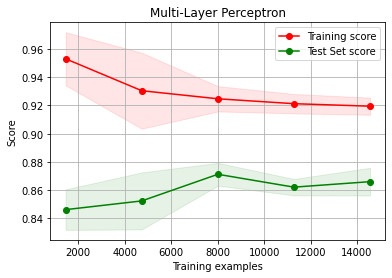

In [20]:
plt.figure()
plt.title("Multi-Layer Perceptron")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(mlp, X_train, np.ravel(y_train),cv=3, 
                                                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Test Set score")

plt.legend(loc="best")
plt.show()

As you can see, the training and test scores are converging and the generalization gap is positive, implying that the model is not overfitting.

In [21]:
mlp.fit(X_train,np.ravel(y_train))

MLPClassifier(hidden_layer_sizes=(32, 16, 8, 4), learning_rate='adaptive',
              max_iter=1000)

In [22]:
test["pred"] = mlp.predict_proba(X_test)[:,1]

In [23]:
print("\n")
print("The accuracy score is : " + str(mlp.score(X_test,y_test)))
print("The recall score is : " + str(recall_score(test["outcome"],test["pred"].round(0))))
print("The precision score is : " + str(precision_score(test["outcome"],test["pred"].round(0))))
print("\n")



The accuracy score is : 0.8624849215922799
The recall score is : 0.36752136752136755
The precision score is : 0.5180722891566265




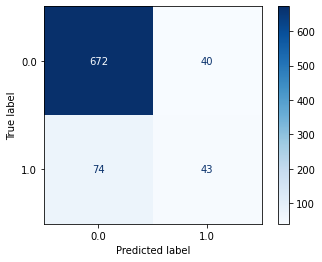

In [24]:
plot_confusion_matrix(mlp,X_test,y_test, cmap='Blues')
plt.show()

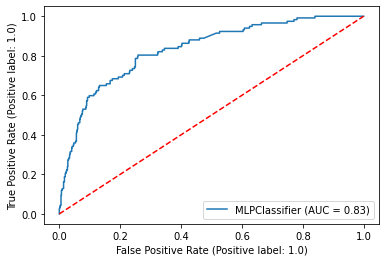

In [25]:
plot_roc_curve(mlp, X_test, y_test, drop_intermediate=False)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.show() 

Despite the low recall score, the model overall performance is satisfactory and serves the purpose of associating the likelihood of a goal to a given shot. The amount of True Positives could be higher but that would be at the expense of many more False Positives.